# Trivial example: linear regression

This is a rather trivial example, but it contains all necessary elements to train an emulator using Feed Forward Neural Networks alghorithms. In particular we are going to use Machine Learning to learn a linear relation of this type
```
y = a*x + b
```
where `a` and `b` are parameters and `x` is the unique feature.

To do so, the main tasks will be:
- generate a sample of data
- build and train a simple architecture
- test what the emulator learned.

NOTE: this example contains enough documentation to learn the basics. In case, refer to `simple_sample.yaml`, `simple_train.yaml`, `planck_sample.yaml` and `planck_train.yaml` for additional information about the parameters to use and the possible choices.

### Load libraries and initialise relevant classes

Load libraries: in this example we are first going to generate a sample (using the Sample class), and then build an emulator (using the FFNNEmu class). Here we are calling diectly the architecture we are going to use (instead of the base class Emulator), but it would be equivalent to call Emulator with a string specifying the type of emulator.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from emu_like.sample import Sample
from emu_like.ffnn_emu import FFNNEmu

2024-01-30 10:46:49.207869: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 10:46:49.209808: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-30 10:46:49.234720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 10:46:49.234748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 10:46:49.235369: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
sample = Sample()
emu = FFNNEmu()

### Generate the sample

Define a dictionary of parameters. This should contain all the parameters that are needed by the function we are going to sample. In this example we are trying to fit a linear relation of the type
```
y = a*x + b
```
as defined in the `linear_1D` function in `src/emu_like/sampling_functions.py`.
`x` is the variable we are going to vary, while `a` and `b` are fixed parameters.

Each fixed parameter should have just a value, while for variables we need to specify
a prior. The `prior` key should contain `min` and `max` parameters in most cases, except for gaussianly distributed priors, where it `loc` (mean) and `scale` (standard deviation) keys are expected.

Defining a custom function is relatively simple: just add a new function to `src/emu_like/sampling_functions.py`, mimicking the existing ones.

In [3]:
params = {
  'x': {
      'prior': {
          'min': -1.,
          'max': 4.,
      },
  },
  'a': 2.,
  'b': -1.
}

Here we are generating the sample. On top of the previously described `params`, the `generate` method wants to know what is the function we are going to sample (`sampled_function`), the number of samples (`n_samples`) and the spacing (all the possibilities are described in `src/emu_like/samplers.py`). This method gives the possibility to incrementally save progresses (useful when the evaluation of the sampled_function takes some time). In case we want to use this option, it is necessary to specify an `output_path`, i.e. a folder that is going to store the sample.

In [4]:
sample.generate(
    params,
    sampled_function='linear_1d',
    n_samples=1000,
    spacing='grid',
    save_incrementally=False,
    output_path=None,
    verbose=True)

[info] Generating sample.
----> Sampled function: linear_1d
----> Number of samples: 1000
----> Spacing: grid
[info] Initializing Grid sampler.


100%|██████████| 999/999 [00:00<00:00, 562506.34it/s]


Once the sample is generated, we are going to randomly split it into train and test sample. We have to fix the fractional amount of data for the training sample and the random seed used for the splitting.

In [5]:
sample.train_test_split(
    frac_train=0.9,
    seed=1543,
    verbose=True)

[info] Splitting training and testing samples.
----> Fractional number of training samples: 0.9
----> Random seed for train/test split: 1543


To train more efficiently the emulator it is often useful to rescale both `x` and `y` to have them of order 1. The list of possible scalers can be found at `simple_train.yaml` (or in the source code at `src/emu_like/scalers.py`, where you can also add new scalers).

In [6]:
sample.rescale(
    rescale_x = 'StandardScaler',
    rescale_y = 'MinMaxScalerPlus1',
    verbose=True)

[info] Rescaling x and y.
----> x with: StandardScaler
----> y with: MinMaxScalerPlus1
----> Rescaled bounds:
--------> x_train_0 = [-1.7284147042373472, 1.7432962234401823]
--------> x_test_0 = [-1.7179891458959733, 1.7328706650988084]
--------> y_train_0 = [1.0, 2.0]
--------> y_test_0 = [1.003003003003003, 1.9969969969969972]


### Build and train the emulator

After the sample is generated, we have to build the emulator architecture and train it.
Building the architecture consists in defining a set of parameters `params` and pass it to the `build` method. The parameters one should specify are listed below, and they are explained in depth in `simple_train.yaml` and `planck_train.yaml`.

In particular, for linear regression a neural network can be very simple, i.e. without hidden layers.

In [7]:
params = {
    'activation': 'relu',
    'neurons_hidden': [],
    'batch_normalization': False,
    'dropout_rate': 0.,
    'optimizer': 'adam',
    'loss': 'keras.losses.mean_squared_error',
    'epochs': 1000,
    'batch_size': 32,
    'want_output_layer': True,
    'learning_rate': 1.e-3,
    'sample_n_x': sample.n_x,
    'sample_n_y': sample.n_y,
}

In [8]:
emu.build(
    params,
    verbose=True)

[info] Building FFNN architecture
----> Activation function: relu
----> Dropout rate: 0.0
----> Optimizer: adam
----> Loss function: keras.losses.mean_squared_error
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It is now time to train the emulator. One has to pass a Sample object (already loaded, splitted into train and test samples and rescaled), the number of `epochs`, the `learning_rate` and the `batch_size`. It is possible also to save the emulator providing `path`

Epoch 1/1000
29/29 [==============================] - 0s 4ms/step - loss: 1.5778 - val_loss: 1.4832
Epoch 2/1000
29/29 [==============================] - 0s 1ms/step - loss: 1.4376 - val_loss: 1.3399
Epoch 3/1000
29/29 [==============================] - 0s 1ms/step - loss: 1.3053 - val_loss: 1.2051
Epoch 4/1000
29/29 [==============================] - 0s 1ms/step - loss: 1.1821 - val_loss: 1.0821
Epoch 5/1000
29/29 [==============================] - 0s 1ms/step - loss: 1.0695 - val_loss: 0.9698
Epoch 6/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.9665 - val_loss: 0.8690
Epoch 7/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.8745 - val_loss: 0.7810
Epoch 8/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.7923 - val_loss: 0.7039
Epoch 9/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.7213 - val_loss: 0.6374
Epoch 10/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.6599 - val_loss: 0.5823

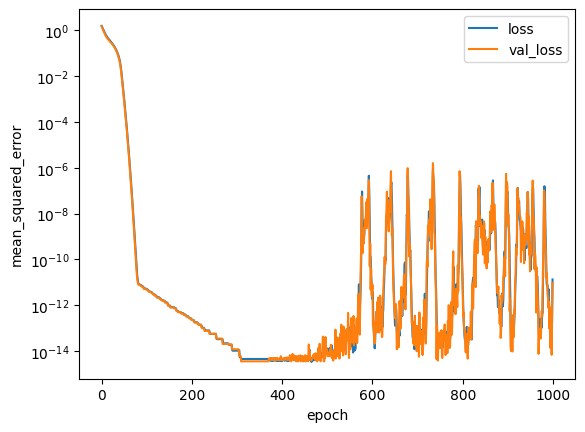

In [9]:
emu.train(
    sample,
    epochs=1000,
    learning_rate=1.e-3,
    batch_size=32,
    path=None,
    get_plot=True,
    verbose=True)

### Testing the result

In the next cell we are going to evaluate the emulator on the sample points, and then we plot the input `y` against the emulated ones. In the last plot, where we show the relative differences, it is possible to notice that the relative difference is noticeable only when the curves are passing through zero (an artifact of dividing by zero).

In [10]:
y_emu = np.array([emu.eval(x) for x in sample.x])

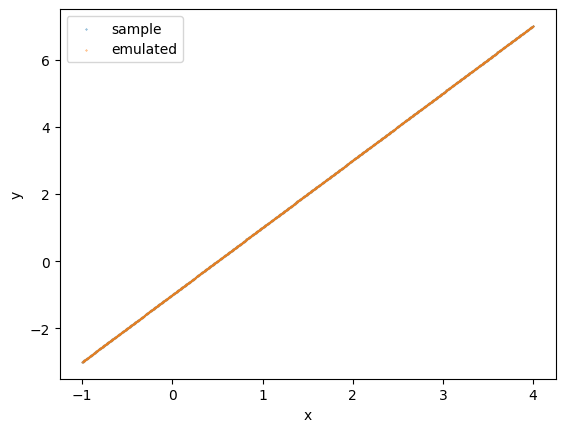

In [11]:
plt.scatter(sample.x[:,0], sample.y[:,0], s=0.1, label='sample')
plt.scatter(sample.x[:,0], y_emu[:,0], s=0.1, label='emulated')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

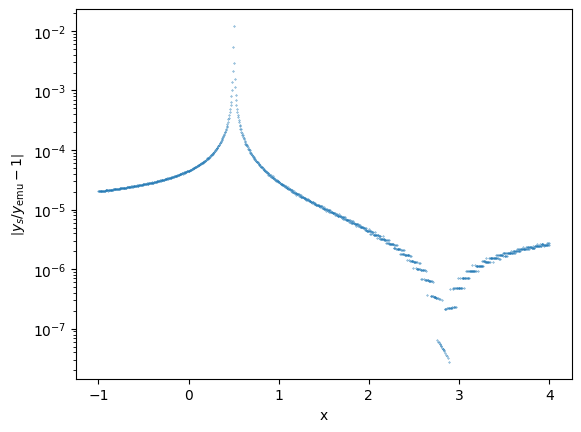

In [12]:
plt.scatter(sample.x[:,0], np.abs(y_emu[:,0]/sample.y[:,0]-1.), s=0.1)
plt.xlabel('x')
plt.ylabel('$\\left|y_s/y_\\mathrm{emu}-1\\right|$')
plt.yscale('log')